In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation, PillowWriter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

print("Libraries imported successfully!")
print(f"QuTiP version: {qutip.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
QuTiP version: 5.2.1
NumPy version: 2.3.4


## 1. Landau-Zener Model Setup

We'll define the Hamiltonian and the time-dependent energy bias function.

In [2]:
# Define Landau-Zener model parameters
class LandauZenerModel:
    def __init__(self, Delta=1.0, epsilon_initial=-5.0, epsilon_final=5.0):
        """
        Initialize Landau-Zener model parameters
        """
        self.Delta = Delta
        self.epsilon_initial = epsilon_initial
        self.epsilon_final = epsilon_final
        
        # Define Pauli matrices
        self.sigma_x = sigmax()
        self.sigma_z = sigmaz()
        self.sigma_y = sigmay()
        
        print(f"Landau-Zener Model initialized:")
        print(f"  Δ (tunneling amplitude): {self.Delta}")
        print(f"  ε_initial: {self.epsilon_initial}")
        print(f"  ε_final: {self.epsilon_final}")
    
    def epsilon(self, t, T):
        """
        Linear sweep of energy bias from epsilon_initial to epsilon_final
        """
        return self.epsilon_initial + (self.epsilon_final - self.epsilon_initial) * t / T
    
    def hamiltonian(self, t, T):
        """
        Time-dependent Hamiltonian H(t) = -delta sigma_x - epsilon(t) sigma_z
        """
        eps_t = self.epsilon(t, T)
        return -self.Delta * self.sigma_x - eps_t * self.sigma_z
    
    def instantaneous_ground_state(self, t, T):
        """
        Calculate the instantaneous ground state at time t
        """
        H_t = self.hamiltonian(t, T)
        eigenvalues, eigenstates = H_t.groundstate()
        return eigenstates, eigenvalues

# Initialize the model
lz_model = LandauZenerModel(Delta=1.0, epsilon_initial=-5.0, epsilon_final=5.0)

Landau-Zener Model initialized:
  Δ (tunneling amplitude): 1.0
  ε_initial: -5.0
  ε_final: 5.0


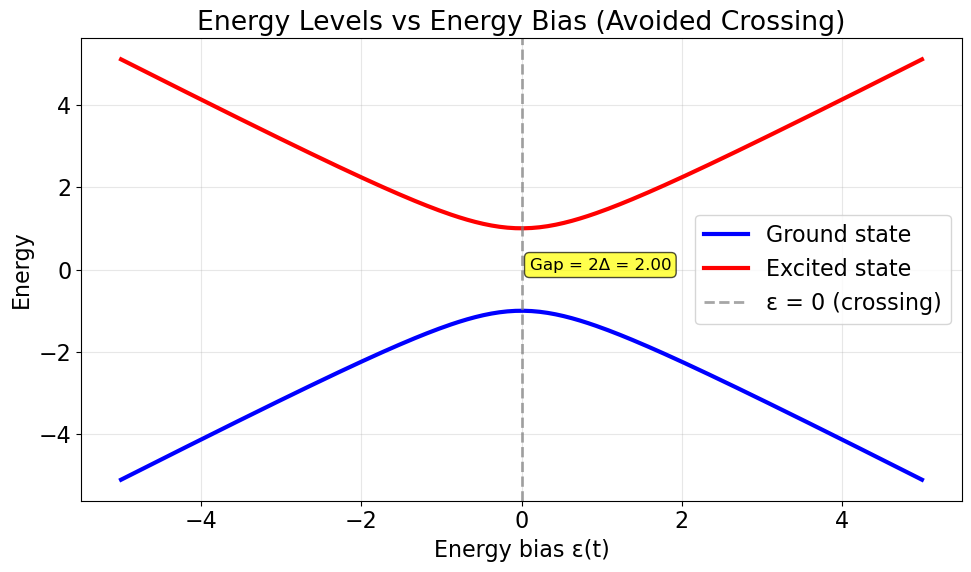

Energy gap at avoided crossing: 2.000


In [3]:
# Visualize the avoided crossing
def plot_energy_levels(lz_model, T=10.0):
    """
    Plot the energy levels as a function of time to visualize the avoided crossing
    """
    t_points = np.linspace(0, T, 200)
    energies_0 = []  # Ground state
    energies_1 = []  # Excited state
    epsilon_values = []
    
    for t in t_points:
        H_t = lz_model.hamiltonian(t, T)
        eigenvals = H_t.eigenenergies()
        energies_0.append(eigenvals[0])  # Ground state (lowest energy)
        energies_1.append(eigenvals[1])  # Excited state
        epsilon_values.append(lz_model.epsilon(t, T))
    
    
    # Plot energy levels vs epsilon
    plt.plot(epsilon_values, energies_0, 'b-', label='Ground state', linewidth=3)
    plt.plot(epsilon_values, energies_1, 'r-', label='Excited state', linewidth=3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7, label='ε = 0 (crossing)')
    plt.xlabel('Energy bias ε(t)')
    plt.ylabel('Energy')
    plt.title('Energy Levels vs Energy Bias (Avoided Crossing)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Calculate and display the gap at the avoided crossing
    H_crossing = lz_model.hamiltonian(T/2, T)  # At ε = 0
    gap = H_crossing.eigenenergies()[1] - H_crossing.eigenenergies()[0]
    plt.text(0.1, 0, f'Gap = 2Δ = {gap:.2f}', fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    plt.tight_layout()
    plt.show()
    
    return gap

# Plot the energy levels
gap = plot_energy_levels(lz_model)
print(f"Energy gap at avoided crossing: {gap:.3f}")

---

# QUBO and Ising Models for Quantum Annealing

## Introduction

This section demonstrates how optimization problems are encoded as QUBO (Quadratic Unconstrained Binary Optimization) or Ising models for quantum annealing. We'll implement examples and visualize the energy landscapes.

Number of vertices: 5
Number of edges: 6
Maximum cut size: 5
Optimal partition: [1, 0, 0, 1, 0]


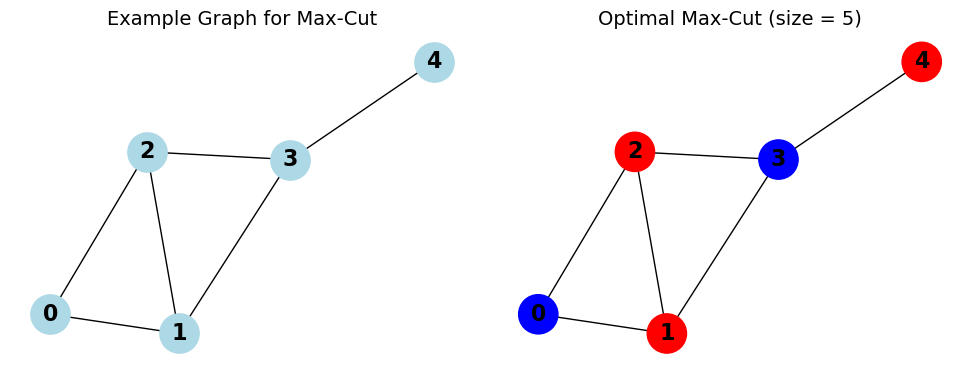

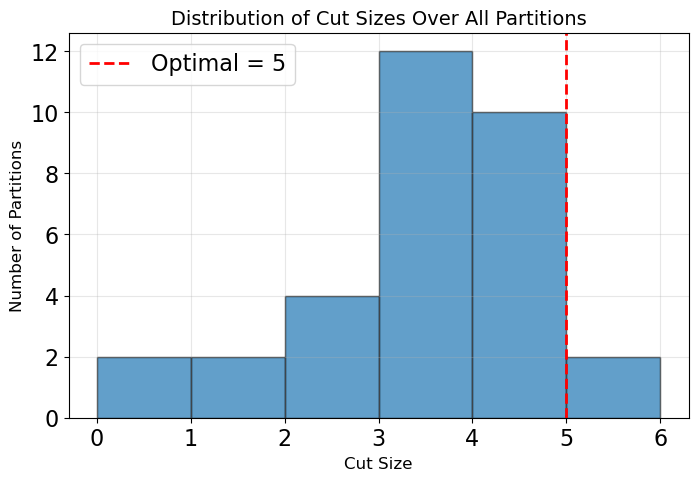


QUBO Matrix:
[[-2.  2.  2.  0.  0.]
 [ 0. -3.  2.  2.  0.]
 [ 0.  0. -3.  2.  0.]
 [ 0.  0.  0. -3.  2.]
 [ 0.  0.  0.  0. -1.]]

Ising Couplings: {(0, 1): 1.0, (0, 2): 1.0, (1, 2): 1.0, (1, 3): 1.0, (2, 3): 1.0, (3, 4): 1.0}


In [4]:
# Example 1: Max-Cut Problem
# Given a graph, partition vertices to maximize edges between partitions

import networkx as nx

class MaxCutProblem:
    """Max-Cut problem formulation"""
    
    def __init__(self, graph):
        self.graph = graph
        self.n_vertices = len(graph.nodes())
        
    def qubo_matrix(self):
        """Generate QUBO matrix for max-cut"""
        n = self.n_vertices
        Q = np.zeros((n, n))
        
        # For max-cut: maximize sum of (x_i - x_j)^2 over edges
        # Equivalent to minimizing: -sum of (x_i + x_j - 2*x_i*x_j)
        for i, j in self.graph.edges():
            Q[i, i] += -1
            Q[j, j] += -1
            if i < j:
                Q[i, j] += 2
            else:
                Q[j, i] += 2
        
        return Q
    
    def ising_parameters(self):
        """Convert to Ising formulation"""
        J = {}  # Coupling matrix
        h = np.zeros(self.n_vertices)  # Local fields
        
        # For max-cut in Ising: minimize sum of s_i * s_j over edges
        for i, j in self.graph.edges():
            J[(i, j)] = 1.0  # Antiferromagnetic for max-cut
        
        return J, h
    
    def evaluate_qubo(self, x):
        """Evaluate QUBO objective for binary vector x"""
        Q = self.qubo_matrix()
        return x @ Q @ x
    
    def evaluate_ising(self, s):
        """Evaluate Ising energy for spin configuration s"""
        J, h = self.ising_parameters()
        energy = 0
        for (i, j), coupling in J.items():
            energy += coupling * s[i] * s[j]
        for i in range(len(s)):
            energy += h[i] * s[i]
        return energy
    
    def cut_size(self, partition):
        """Calculate the actual cut size"""
        cut = 0
        for i, j in self.graph.edges():
            if partition[i] != partition[j]:
                cut += 1
        return cut

# Create a small example graph
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)])

# Visualize the graph
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=800, font_size=16, font_weight='bold')
plt.title('Example Graph for Max-Cut', fontsize=14)

# Try all possible partitions and find optimal
max_cut = MaxCutProblem(G)
n = max_cut.n_vertices
best_cut = 0
best_partition = None

all_cuts = []
for i in range(2**n):
    # Binary representation
    partition = [(i >> j) & 1 for j in range(n)]
    cut = max_cut.cut_size(partition)
    all_cuts.append(cut)
    if cut > best_cut:
        best_cut = cut
        best_partition = partition

print(f"Number of vertices: {n}")
print(f"Number of edges: {len(G.edges())}")
print(f"Maximum cut size: {best_cut}")
print(f"Optimal partition: {best_partition}")

# Visualize best partition
plt.subplot(1, 2, 2)
node_colors = ['red' if best_partition[node] == 0 else 'blue' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, 
        node_size=800, font_size=16, font_weight='bold')
plt.title(f'Optimal Max-Cut (size = {best_cut})', fontsize=14)

plt.tight_layout()
plt.savefig('figures/maxcut_example.png', dpi=300, bbox_inches='tight')
plt.show()

# Show distribution of cut sizes
plt.figure(figsize=(8, 5))
plt.hist(all_cuts, bins=range(max(all_cuts)+2), alpha=0.7, edgecolor='black')
plt.xlabel('Cut Size', fontsize=12)
plt.ylabel('Number of Partitions', fontsize=12)
plt.title('Distribution of Cut Sizes Over All Partitions', fontsize=14)
plt.axvline(best_cut, color='red', linestyle='--', linewidth=2, label=f'Optimal = {best_cut}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/maxcut_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nQUBO Matrix:")
print(max_cut.qubo_matrix())
print(f"\nIsing Couplings: {max_cut.ising_parameters()[0]}")

In [5]:
# Define Pauli matrices
sigma_x = sigmax()
sigma_y = sigmay()
sigma_z = sigmaz()
identity = qeye(2)

## Adiabatic GIF

In [ ]:

# Quantum box parameters
L0 = 1.0         # Initial box length
L1 = 2.0         # Final box length
N = 1000         # Number of spatial points
x = np.linspace(0, L1, N)
n = 1            # Ground state

def psi_box(x, L, n):
    """Ground state wavefunction in box of length L."""
    psi = np.sqrt(2/L) * np.sin(n * np.pi * x / L)
    psi[x > L] = 0
    return psi

In [7]:
# ...existing code...

def abrupt_schedule(t, T):
    """Abrupt change: wall jumps at t=0.5*T."""
    return L0 if t < 0.5*T else L1

def adiabatic_schedule(t, T):
    """Smooth linear change."""
    return L0 + (L1 - L0) * t / T

In [8]:
# ...existing code...

def animate_wavefunction(schedule, T, nframes, title, filename):
    fig, ax = plt.subplots(figsize=(6, 4))
    line, = ax.plot([], [], 'b-', lw=2)
    ax.set_xlim(0, L1)
    ax.set_ylim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel(r'$|\psi(x)|^2$')
    ax.set_title(title)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        t = frame / nframes * T
        L = schedule(t, T)
        psi = psi_box(x, L, n)
        prob = np.abs(psi)**2
        line.set_data(x, prob)
        ax.set_xlim(0, L1)
        ax.set_ylim(0, 2)
        ax.axvline(L, color='k', ls='--', alpha=0.5)
        return line,

    anim = FuncAnimation(fig, update, frames=nframes, init_func=init, blit=True)
    #anim.save(filename, writer=PillowWriter(fps=20))
    plt.close()
    #print(f"Saved: {filename}")

In [9]:
T = 2.0
nframes = 60

# Abrupt change
animate_wavefunction(
    abrupt_schedule, T, nframes,
    "Abrupt Change in Potential (Non-Adiabatic)",
    "abrupt_change.gif"
)

# Adiabatic (smooth) change
animate_wavefunction(
    adiabatic_schedule, T, nframes,
    "Adiabatic Change in Potential (Adiabatic Theorem)",
    "adiabatic_change.gif"
)

In [10]:
"""Simple time propagation for the Schroedinger equation"""
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla
import scipy.sparse as sp


def propagate(ham, psi, delta_t, tridiag=False):
    """Propagage the wave function `psi` by time `delta_t` using the hamiltonian
    `ham`. Uses the Crank-Nicolson method.
    """

    if sp.isspmatrix_dia(ham):
        # Optimization for banded matrices
        denom = ham.copy()
        denom.data *= 0.5j * delta_t
        denom.data[denom.offsets==0, :] += 1.0
        numer = sp.eye(ham.shape[0], format='csr') - 0.5j * ham.tocsr() * delta_t
        denom, l, u = _make_banded_matrix(denom.todia())
        temp = la.solve_banded((l, u), denom, psi)
        return numer.dot(temp)
    if sp.isspmatrix(ham):
        denom = sp.eye(ham.shape[0]) + 0.5j * ham * delta_t
        numer = sp.eye(ham.shape[0]) - 0.5j * ham * delta_t
        temp = sla.spsolve(denom, psi)
        return numer.dot(temp)
    else:
        denom = np.eye(ham.shape[0]) + 0.5j * ham * delta_t
        numer = np.eye(ham.shape[0]) - 0.5j * ham * delta_t
        temp = la.solve(denom, psi)
        return np.dot(numer, temp)


def _make_banded_matrix(ham):
    """Turn a sparse dia_matrix into a banded matrix
       format understood by scipy.linalg.solve_banded.
    """

    N = ham.shape[0]
    u = ham.offsets.max()
    l = ham.offsets.min()
    banded = np.zeros(shape=(1+u-l, N), dtype=complex)
    for k, offset in enumerate(ham.offsets):
        banded[u - offset, :] = ham.data[k, :]
        
    return banded, -l, u


In [11]:
"""Simulations related to the adiabatic approximation"""

import numpy as np
import scipy.sparse
import scipy.linalg as la

import matplotlib.animation
import matplotlib.pyplot as plt


def make_adiabatic_potential_animation(potential, L=200):

    x = np.arange(L)
    ham, pot = _make_hamiltonian(L, potential, 0)
    psi_0 = la.eigh(ham.todense())[1][:, 0]

    psis = []
    pots = []
    psi = psi_0.copy()
    for n in range(300):
        ham, pot = _make_hamiltonian(L, potential, n)
        if n%3 == 0:
            pots.append(pot)
            psis.append(psi)
        psi = propagate(ham, psi, 10)
    
    fig, ax = plt.subplots(figsize=(8,3))
    plt.close()  # this prevents the output of an empty frame
    l1, = ax.plot(x, abs(psis[0])**2, label="$|\psi(x)|^2$")
    l2, = ax.plot(x, pots[0], label="$V(x)$")
    ax.set_xlabel("$x$")
    ax.legend(loc="upper right")
    ax.set_ylim(0, 0.05)

    def animate(i):
        l1.set_data(x, abs(psis[i])**2)
        l2.set_data(x, pots[i])
        return (l1, l2)

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(psis), interval=50)
    
    return anim

def _make_hamiltonian(L=100, pot_func=None, time=0, t=1):
    
    ham = np.zeros(shape=(L, L), dtype=complex)
    
    if pot_func is not None:
        pot = np.array([pot_func(i, time) for i in range(L)], dtype=float)
    else:
        pot = np.zeros(shape=(L,), dtype=float)

    np.fill_diagonal(ham, 2 * t + pot)
    
    offdiag = np.zeros(shape=(L-1,), dtype=complex)
    offdiag[:] = -t
    np.fill_diagonal(ham[1:, :-1], offdiag)
    np.fill_diagonal(ham[:-1, 1:], offdiag)
    
    # finally, periodic boundary conditions
    ham[0, -1] = -t
    ham[-1, 0] = -t
    
    return scipy.sparse.csr_matrix(ham), pot

In [12]:
"""Simulations related to the adiabatic approximation"""

import numpy as np
import scipy.sparse
import scipy.linalg as la

import matplotlib.animation
import matplotlib.pyplot as plt


def make_adiabatic_potential_animation(potential, L=200):

    x = np.arange(L)
    ham, pot = _make_hamiltonian(L, potential, 0)
    psi_0 = la.eigh(ham.todense())[1][:, 0]

    psis = []
    pots = []
    psi = psi_0.copy()
    for n in range(300):
        ham, pot = _make_hamiltonian(L, potential, n)
        if n%3 == 0:
            pots.append(pot)
            psis.append(psi)
        psi = propagate(ham, psi, 10)
    
    fig, ax = plt.subplots(figsize=(8,3))
    plt.close()  # this prevents the output of an empty frame
    l1, = ax.plot(x, abs(psis[0])**2, label="$|\psi(x)|^2$")
    l2, = ax.plot(x, pots[0], label="$V(x)$")
    ax.set_xlabel("$x$")
    ax.legend(loc="upper right")
    ax.set_ylim(0, 0.05)

    def animate(i):
        l1.set_data(x, abs(psis[i])**2)
        l2.set_data(x, pots[i])
        return (l1, l2)

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(psis), interval=50)
    
    return anim

def _make_hamiltonian(L=100, pot_func=None, time=0, t=1):
    
    ham = np.zeros(shape=(L, L), dtype=complex)
    
    if pot_func is not None:
        pot = np.array([pot_func(i, time) for i in range(L)], dtype=float)
    else:
        pot = np.zeros(shape=(L,), dtype=float)

    np.fill_diagonal(ham, 2 * t + pot)
    
    offdiag = np.zeros(shape=(L-1,), dtype=complex)
    offdiag[:] = -t
    np.fill_diagonal(ham[1:, :-1], offdiag)
    np.fill_diagonal(ham[:-1, 1:], offdiag)
    
    # finally, periodic boundary conditions
    ham[0, -1] = -t
    ham[-1, 0] = -t
    
    return scipy.sparse.csr_matrix(ham), pot

In [27]:
from IPython.display import HTML, display
import numpy as np

L = 200
def pot_abrupt(i, t):
    if t < 50:
        width = L/1.7
    else:
        width = L
    return np.tanh((i - width + 30) / 5) + 1 - np.tanh((i - 30) / 5) + 1

anim = make_adiabatic_potential_animation(potential=pot_abrupt)
anim.save('figures/adiabatic_potential_animation.gif')
print("Animation saved to adiabatic_potential_animation.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved to adiabatic_potential_animation.gif


In [14]:
L = 200
def pot_slow(i, t):
    width = L/1.7 + t/600 * (L - L/1.7)

    return np.tanh((i - width + 30) / 5) + 1 - np.tanh((i - 30) / 5) + 1

anim = make_adiabatic_potential_animation(potential=pot_slow)
anim.save('figures/slow_adiabatic_potential_animation.gif')
print("Animation saved to slow_adiabatic_potential_animation.gif")


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved to slow_adiabatic_potential_animation.gif


# Spin-1/2 in Rotating Magnetic Field: Berry Phase Demonstration

This section demonstrates the **adiabatic theorem** and **Berry phase** for a spin-1/2 particle in a slowly rotating magnetic field.

## The Physical Setup

The magnetic field rotates in a cone around the z-axis:

$$\vec{B}(t) = B_0(\sin\theta\cos\omega t, \sin\theta\sin\omega t, \cos\theta)$$

The Hamiltonian is:

$$\hat{H}(t) = -\gamma\vec{B}(t) \cdot \vec{\sigma} = -\gamma B_0 \begin{pmatrix} \cos\theta & \sin\theta e^{-i\omega t} \\ \sin\theta e^{i\omega t} & -\cos\theta \end{pmatrix}$$

## Key Predictions

1. **Instantaneous eigenvalues**: $E_{\pm} = \mp\gamma B_0$ (independent of time)
2. **Adiabatic condition**: If $\omega \ll \gamma B_0$, the spin follows the magnetic field
3. **Berry phase**: After one full rotation ($t = 2\pi/\omega$), the state acquires a geometric phase:
   $$\gamma_{\text{Berry}} = \pi(1 - \cos\theta)$$

We'll compare:
- **Adiabatic evolution** (slow rotation): spin follows field, Berry phase appears
- **Non-adiabatic evolution** (fast rotation): spin cannot follow, oscillations occur

In [15]:
# Define the spin-1/2 system in a rotating magnetic field
class SpinHalfBerryPhase:
    def __init__(self, B0=1.0, theta=np.pi/3, gamma=1.0):
        """
        Initialize the spin-1/2 system in a rotating magnetic field.
        
        Parameters:
        -----------
        B0 : float
            Magnetic field strength
        theta : float
            Polar angle of the magnetic field cone
        gamma : float
            Gyromagnetic ratio
        """
        self.B0 = B0
        self.theta = theta
        self.gamma = gamma
        
        # Pauli matrices
        self.sx = sigmax()
        self.sy = sigmay()
        self.sz = sigmaz()
        
        # Identity
        self.I = qeye(2)
        
    def hamiltonian(self, t, omega):
        """
        Time-dependent Hamiltonian for rotating magnetic field.
        
        H(t) = -gamma * B0 * (sin(theta)*cos(omega*t)*sx + 
                               sin(theta)*sin(omega*t)*sy + 
                               cos(theta)*sz)
        """
        Bx = np.sin(self.theta) * np.cos(omega * t)
        By = np.sin(self.theta) * np.sin(omega * t)
        Bz = np.cos(self.theta)
        
        H = -self.gamma * self.B0 * (Bx * self.sx + By * self.sy + Bz * self.sz)
        return H
    
    def initial_state(self):
        """
        Initial state aligned with B(t=0) = B0(sin(theta), 0, cos(theta))
        This is the instantaneous ground state at t=0.
        """
        # Eigenstate of H(t=0)
        H0 = self.hamiltonian(0, 0)
        eigvals, eigvecs = H0.eigenstates()
        # Return ground state (lowest energy)
        return eigvecs[0]
    
    def berry_phase_theoretical(self):
        """
        Theoretical Berry phase for one complete rotation.
        gamma_Berry = pi * (1 - cos(theta))
        """
        return np.pi * (1 - np.cos(self.theta))
    
    def evolve_system(self, omega, n_periods=1, n_steps=200):
        """
        Evolve the spin system for n_periods of rotation.
        
        Parameters:
        -----------
        omega : float
            Angular frequency of rotation
        n_periods : int
            Number of complete rotations
        n_steps : int
            Number of time steps per period
        
        Returns:
        --------
        times : array
            Time points
        states : list
            Quantum states at each time
        """
        T = 2 * np.pi / omega  # Period of one rotation
        t_final = n_periods * T
        times = np.linspace(0, t_final, n_periods * n_steps)
        
        # Initial state
        psi0 = self.initial_state()
        
        # Time-dependent Hamiltonian as a list [H0, [H1, f1(t)], ...]
        # H(t) = -gamma*B0*(sin(theta)*(cos(omega*t)*sx + sin(omega*t)*sy) + cos(theta)*sz)
        H0 = -self.gamma * self.B0 * np.cos(self.theta) * self.sz
        H_cos = -self.gamma * self.B0 * np.sin(self.theta) * self.sx
        H_sin = -self.gamma * self.B0 * np.sin(self.theta) * self.sy
        
        H = [H0, [H_cos, lambda t, args: np.cos(omega * t)], 
                 [H_sin, lambda t, args: np.sin(omega * t)]]
        
        # Solve Schrodinger equation
        result = sesolve(H, psi0, times, [])
        
        return times, result.states

print("SpinHalfBerryPhase class defined successfully!")
print("This class simulates a spin-1/2 particle in a rotating magnetic field.")

SpinHalfBerryPhase class defined successfully!
This class simulates a spin-1/2 particle in a rotating magnetic field.


In [16]:
# Helper functions for visualization
def compute_expectation_values(states, sx, sy, sz):
    """
    Compute expectation values of spin components.
    
    Returns:
    --------
    sx_exp, sy_exp, sz_exp : arrays
        Expectation values <sx>, <sy>, <sz> at each time
    """
    sx_exp = np.array([expect(sx, state) for state in states])
    sy_exp = np.array([expect(sy, state) for state in states])
    sz_exp = np.array([expect(sz, state) for state in states])
    
    return sx_exp, sy_exp, sz_exp

def compute_magnetic_field_direction(times, theta, omega):
    """
    Compute the direction of the magnetic field as a function of time.
    """
    Bx = np.sin(theta) * np.cos(omega * times)
    By = np.sin(theta) * np.sin(omega * times)
    Bz = np.cos(theta) * np.ones_like(times)
    
    return Bx, By, Bz

def compute_berry_phase_from_evolution(states, psi0):
    """
    Compute the Berry phase from the final state after one complete rotation.
    
    The Berry phase is the argument of <psi_final|psi_0> after removing the 
    dynamical phase (which is zero for this case since eigenvalues don't change).
    """
    psi_final = states[-1]
    
    # Compute overlap
    overlap = psi_final.overlap(psi0)
    
    # Extract phase
    phase = np.angle(overlap)
    
    return phase

print("Visualization helper functions defined!")
print("- compute_expectation_values: Track spin direction")
print("- compute_magnetic_field_direction: Track field direction")
print("- compute_berry_phase_from_evolution: Extract Berry phase")

Visualization helper functions defined!
- compute_expectation_values: Track spin direction
- compute_magnetic_field_direction: Track field direction
- compute_berry_phase_from_evolution: Extract Berry phase


In [17]:
# Create the spin system and compare adiabatic vs non-adiabatic evolution
B0 = 1.0
theta = np.pi / 3  # 60 degrees
gamma = 1.0

spin_system = SpinHalfBerryPhase(B0=B0, theta=theta, gamma=gamma)

# Define two rotation frequencies
# Adiabatic: omega << gamma*B0
omega_adiabatic = 0.05 * gamma * B0  

# Non-adiabatic: omega ~ gamma*B0
omega_nonadiabatic = 1.0 * gamma * B0

print(f"System parameters:")
print(f"  B0 = {B0}")
print(f"  theta = {theta:.3f} rad = {np.degrees(theta):.1f}°")
print(f"  gamma = {gamma}")
print(f"  gamma*B0 = {gamma*B0:.3f} (characteristic frequency)")
print(f"\nRotation frequencies:")
print(f"  Adiabatic: omega = {omega_adiabatic:.4f} (slow)")
print(f"  Non-adiabatic: omega = {omega_nonadiabatic:.4f} (fast)")
print(f"\nTheoretical Berry phase: {spin_system.berry_phase_theoretical():.4f} rad")
print(f"                        = {np.degrees(spin_system.berry_phase_theoretical()):.2f}°")

# Evolve both systems for one complete rotation
print("\nEvolving adiabatic system...")
times_adiabatic, states_adiabatic = spin_system.evolve_system(
    omega_adiabatic, n_periods=1, n_steps=200
)

print("Evolving non-adiabatic system...")
times_nonadiabatic, states_nonadiabatic = spin_system.evolve_system(
    omega_nonadiabatic, n_periods=1, n_steps=200
)

print("Evolution complete!")

System parameters:
  B0 = 1.0
  theta = 1.047 rad = 60.0°
  gamma = 1.0
  gamma*B0 = 1.000 (characteristic frequency)

Rotation frequencies:
  Adiabatic: omega = 0.0500 (slow)
  Non-adiabatic: omega = 1.0000 (fast)

Theoretical Berry phase: 1.5708 rad
                        = 90.00°

Evolving adiabatic system...
Evolving non-adiabatic system...
Evolution complete!


In [20]:
# Create a combined vertical comparison animation (or save frames as PNGs)
def create_comparison_animation(times_adia, sx_adia, sy_adia, sz_adia, Bx_adia, By_adia, Bz_adia, omega_adia,
                                times_nadia, sx_nadia, sy_nadia, sz_nadia, Bx_nadia, By_nadia, Bz_nadia, omega_nadia,
                                filename='figures/berry_phase_comparison.gif', n_frames=100, save_frames=False, frames_dir='figures/frames_berry_phase'):
    """
    Create vertical comparison of adiabatic and non-adiabatic evolution (one above the other).

    If save_frames=True, the function will render each frame and save it as a PNG into `frames_dir`
    (naming: frame_0000.png ...). Otherwise it creates and saves a GIF at `filename` as before.

    This version turns off the 3D axis grid/panes and only shows a legend on the first subplot
    (so the second subplot will have no legend).
    """
    import os
    import shutil

    fig = plt.figure(figsize=(8, 12))
    
    # Create subplots stacked vertically (2 rows, 1 column)
    ax1 = fig.add_subplot(211, projection='3d')
    ax2 = fig.add_subplot(212, projection='3d')
    
    axes = [ax1, ax2]
    data_sets = [
        (times_adia, sx_adia, sy_adia, sz_adia, Bx_adia, By_adia, Bz_adia),
        (times_nadia, sx_nadia, sy_nadia, sz_nadia, Bx_nadia, By_nadia, Bz_nadia)
    ]
    
    # Unit sphere coordinates
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_sphere = 0.98 * np.outer(np.cos(u), np.sin(v))
    y_sphere = 0.98 * np.outer(np.sin(u), np.sin(v))
    z_sphere = 0.98 * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Helper to disable grid/panes on a 3D Axes
    def disable_3d_grid(ax):
        try:
            ax.grid(False)
        except Exception:
            pass
        # Turn off pane fills for a cleaner background
        try:
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
        except Exception:
            pass
        # Also remove the pane edge lines if present
        try:
            ax.xaxis.pane.set_edgecolor((1,1,1,0))
            ax.yaxis.pane.set_edgecolor((1,1,1,0))
            ax.zaxis.pane.set_edgecolor((1,1,1,0))
        except Exception:
            pass

    # Set up both 3D plots
    for ax in axes:
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.set_zlim([-1.2, 1.2])
        ax.set_xlabel('X', fontsize=11, fontweight='bold')
        ax.set_ylabel('Y', fontsize=11, fontweight='bold')
        ax.set_zlabel('Z', fontsize=11, fontweight='bold')
        disable_3d_grid(ax)
        ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.08, color='lightgray')
        ax.view_init(elev=20, azim=45)
    
    # Sample frames
    frame_indices_adia = np.linspace(0, len(times_adia)-1, n_frames, dtype=int)
    frame_indices_nadia = np.linspace(0, len(times_nadia)-1, n_frames, dtype=int)
    
    def update(frame_num):
        idx_adia = frame_indices_adia[frame_num]
        idx_nadia = frame_indices_nadia[frame_num]
        indices = [idx_adia, idx_nadia]
        
        for i, (ax, (times, sx, sy, sz, Bx, By, Bz)) in enumerate(zip(axes, data_sets)):
            ax.clear()

            idx = indices[i]

            # Redraw sphere
            ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.08, color='lightgray')

            # Plot trajectory
            ax.plot(sx[:idx+1], sy[:idx+1], sz[:idx+1], 'b-', linewidth=2.5, alpha=0.7, label='Spin path')

            # Current spin vector
            ax.quiver(0, 0, 0, sx[idx], sy[idx], sz[idx], 
                     color='blue', arrow_length_ratio=0.2, linewidth=4, label='Spin')

            # Magnetic field vector
            ax.quiver(0, 0, 0, Bx[idx], By[idx], Bz[idx], 
                     color='red', arrow_length_ratio=0.2, linewidth=3, alpha=0.8, label='B field')

            # Initial position marker
            ax.scatter([sx[0]], [sy[0]], [sz[0]], color='green', s=100, marker='o', 
                      alpha=0.8, label='Start')

            # Current position marker
            ax.scatter([sx[idx]], [sy[idx]], [sz[idx]], color='blue', s=80, marker='o')

            ax.set_xlim([-1.2, 1.2])
            ax.set_ylim([-1.2, 1.2])
            ax.set_zlim([-1.2, 1.2])
            ax.set_xlabel('X', fontsize=11, fontweight='bold')
            ax.set_ylabel('Y', fontsize=11, fontweight='bold')
            ax.set_zlabel('Z', fontsize=11, fontweight='bold')

            # Disable grid/panes again because ax.clear() resets them
            #disable_3d_grid(ax)

            # Only show legend on the first subplot (index 0)
            if i == 0:
                ax.legend(loc='upper left', fontsize=9)

            ax.view_init(elev=20, azim=45)

            # Add time info
            ax.text2D(0.02, 0.02, f't = {times[idx]:.2f}', transform=ax.transAxes, 
                     fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # If user wants frames saved as PNGs, render and save each frame
    if save_frames:
        os.makedirs(frames_dir, exist_ok=True)
        # backup existing frames if any
        existing = sorted([p for p in os.listdir(frames_dir) if p.endswith('.png')])
        if existing:
            backup = frames_dir + '_backup_' + __import__('datetime').datetime.now().strftime('%Y%m%d_%H%M%S')
            os.makedirs(backup, exist_ok=True)
            for p in existing:
                shutil.move(os.path.join(frames_dir, p), os.path.join(backup, p))
            print(f"Backed up existing frames to {backup}")

        for frame_num in range(n_frames):
            update(frame_num)
            outpath = os.path.join(frames_dir, f'frame_{frame_num:04d}.png')
            fig.savefig(outpath, dpi=150)
        print(f"Saved {n_frames} frames to {frames_dir}")
        plt.close(fig)
        return None

    # Otherwise create animation GIF as before
    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)

    # Save animation
    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    print(f"Comparison animation saved to {filename}")

    plt.close()

    return anim

print("Prepared comparison animation function (now supports saving frames as PNGs, disabled grid and second legend).")


Prepared comparison animation function (now supports saving frames as PNGs, disabled grid and second legend).


# Landau-Zener Diabatic Transition Animation

This section demonstrates the **diabatic transition** in the Landau-Zener model. We'll show how a wavefunction starting in the instantaneous ground state **fails to follow adiabatically** during a fast sweep through the avoided crossing, resulting in population transfer to the excited state.

## The Landau-Zener Model

The Hamiltonian is:

$$H(t) = -\Delta \sigma_x - \epsilon(t) \sigma_z$$

where $\epsilon(t)$ sweeps linearly from negative to positive values, and $\Delta$ is the avoided crossing strength.

## Key Physics

- **Adiabatic case** (slow sweep): System stays in instantaneous ground state
- **Diabatic case** (fast sweep): System makes transitions at the avoided crossing
- **Landau-Zener formula**: Transition probability $P_{LZ} = e^{-\pi\Delta^2/(2\hbar v)}$ where $v$ is the sweep rate

We'll visualize:
1. The instantaneous eigenstates (dashed lines) as they evolve
2. The actual quantum state (solid blue) as it fails to follow during fast sweep
3. Population transfer at the avoided crossing

In [21]:
# Set up Landau-Zener model and simulate both adiabatic and diabatic cases
class LandauZenerAnimation:
    def __init__(self, Delta=1.0, epsilon_initial=-5.0, epsilon_final=5.0):
        """
        Landau-Zener model for animation
        """
        self.Delta = Delta
        self.epsilon_initial = epsilon_initial
        self.epsilon_final = epsilon_final
        
        # Pauli matrices
        self.sx = sigmax()
        self.sz = sigmaz()
        self.sy = sigmay()
        
    def epsilon(self, t, T):
        """Linear sweep of energy bias"""
        return self.epsilon_initial + (self.epsilon_final - self.epsilon_initial) * t / T
    
    def hamiltonian(self, t, T):
        """Time-dependent Hamiltonian"""
        eps_t = self.epsilon(t, T)
        return -self.Delta * self.sx - eps_t * self.sz
    
    def instantaneous_eigenstates(self, t, T):
        """Get instantaneous eigenstates and eigenvalues at time t"""
        H_t = self.hamiltonian(t, T)
        eigenvalues, eigenstates = H_t.eigenstates()
        return eigenvalues, eigenstates
    
    def evolve_system(self, T, n_points=2500):
        """
        Evolve the system from initial ground state
        
        Returns:
        --------
        times, states, instantaneous_ground_states, instantaneous_excited_states, epsilon_values
        """
        times = np.linspace(0, T, n_points)
        
        # Initial state is ground state at t=0
        H_initial = self.hamiltonian(0, T)
        psi_initial = H_initial.groundstate()[1]
        
        # Time-dependent Hamiltonian
        H0 = -self.Delta * self.sx
        H1 = -self.sz
        H = [H0, [H1, lambda t, args: self.epsilon(t, args['T'])]]
        
        # Solve Schrodinger equation
        result = sesolve(H, psi_initial, times, args={'T': T})
        
        # Compute instantaneous eigenstates at each time
        inst_ground_states = []
        inst_excited_states = []
        epsilon_values = []
        energies_ground = []
        energies_excited = []
        
        for t in times:
            eigenvals, eigenstates = self.instantaneous_eigenstates(t, T)
            inst_ground_states.append(eigenstates[0])
            inst_excited_states.append(eigenstates[1])
            epsilon_values.append(self.epsilon(t, T))
            energies_ground.append(eigenvals[0])
            energies_excited.append(eigenvals[1])
        
        return (times, result.states, inst_ground_states, inst_excited_states, 
                np.array(epsilon_values), np.array(energies_ground), np.array(energies_excited))

# Create LZ model
lz_anim = LandauZenerAnimation(Delta=1.0, epsilon_initial=-5.0, epsilon_final=5.0)

# Simulate fast sweep (diabatic)
T_diabatic = 2.0  # Fast sweep
print(f"Simulating diabatic case (T = {T_diabatic})...")
times_diab, states_diab, ground_diab, excited_diab, eps_diab, E0_diab, E1_diab = lz_anim.evolve_system(T_diabatic, n_points=300)

# Simulate slow sweep (adiabatic)
T_adiabatic = 20.0  # Slow sweep
print(f"Simulating adiabatic case (T = {T_adiabatic})...")
times_adia, states_adia, ground_adia, excited_adia, eps_adia, E0_adia, E1_adia = lz_anim.evolve_system(T_adiabatic, n_points=300)

print("\nSimulation complete!")
print(f"Diabatic case: T = {T_diabatic}, sweep rate v = {(lz_anim.epsilon_final - lz_anim.epsilon_initial)/T_diabatic:.2f}")
print(f"Adiabatic case: T = {T_adiabatic}, sweep rate v = {(lz_anim.epsilon_final - lz_anim.epsilon_initial)/T_adiabatic:.2f}")

Simulating diabatic case (T = 2.0)...
Simulating adiabatic case (T = 20.0)...

Simulation complete!
Diabatic case: T = 2.0, sweep rate v = 5.00
Adiabatic case: T = 20.0, sweep rate v = 0.50


In [22]:
# Compute populations and overlaps
def compute_populations_and_overlaps(states, inst_ground, inst_excited):
    """
    Compute population in ground/excited instantaneous eigenstates
    """
    pop_ground = []
    pop_excited = []
    
    for i, state in enumerate(states):
        # Project onto instantaneous eigenstates
        overlap_g = state.overlap(inst_ground[i])
        overlap_e = state.overlap(inst_excited[i])
        
        pop_ground.append(abs(overlap_g)**2)
        pop_excited.append(abs(overlap_e)**2)
    
    return np.array(pop_ground), np.array(pop_excited)

# Compute for both cases
print("Computing populations...")
pop_g_diab, pop_e_diab = compute_populations_and_overlaps(states_diab, ground_diab, excited_diab)
pop_g_adia, pop_e_adia = compute_populations_and_overlaps(states_adia, ground_adia, excited_adia)

print(f"\nDiabatic case:")
print(f"  Initial ground state population: {pop_g_diab[0]:.4f}")
print(f"  Final ground state population: {pop_g_diab[-1]:.4f}")
print(f"  Final excited state population: {pop_e_diab[-1]:.4f}")
print(f"  → Transition probability: {pop_e_diab[-1]:.4f}")

print(f"\nAdiabatic case:")
print(f"  Initial ground state population: {pop_g_adia[0]:.4f}")
print(f"  Final ground state population: {pop_g_adia[-1]:.4f}")
print(f"  Final excited state population: {pop_e_adia[-1]:.4f}")
print(f"  → Transition probability: {pop_e_adia[-1]:.4f}")

# Compute Landau-Zener transition probability (theoretical)
v_diab = (lz_anim.epsilon_final - lz_anim.epsilon_initial) / T_diabatic
v_adia = (lz_anim.epsilon_final - lz_anim.epsilon_initial) / T_adiabatic
P_LZ_diab = np.exp(-np.pi * lz_anim.Delta**2 / (2 * v_diab))
P_LZ_adia = np.exp(-np.pi * lz_anim.Delta**2 / (2 * v_adia))

print(f"\nLandau-Zener formula prediction:")
print(f"  Diabatic: P_LZ = {P_LZ_diab:.4f}")
print(f"  Adiabatic: P_LZ = {P_LZ_adia:.4f}")

Computing populations...

Diabatic case:
  Initial ground state population: 1.0000
  Final ground state population: 0.4744
  Final excited state population: 0.5256
  → Transition probability: 0.5256

Adiabatic case:
  Initial ground state population: 1.0000
  Final ground state population: 0.9983
  Final excited state population: 0.0017
  → Transition probability: 0.0017

Landau-Zener formula prediction:
  Diabatic: P_LZ = 0.7304
  Adiabatic: P_LZ = 0.0432


In [ ]:
# Create animation showing diabatic transition
def create_lz_animation(times, states, inst_ground, inst_excited, epsilon_vals, 
                        E0, E1, pop_ground, pop_excited, Delta, title, filename, n_frames=100,
                        save_frames=False, frames_dir='figures/frames_lz'):
    """
    Create animation of Landau-Zener transition showing:
    - Energy level diagram with current position
    - Population evolution
    - State vector evolution on Bloch sphere

    If save_frames is True, the function will render each frame and save it as
    PNG images into `frames_dir` (frame_0000.png ...). Otherwise it writes a GIF
    to `filename` as before.
    """
    import os
    from matplotlib.animation import PillowWriter

    fig = plt.figure(figsize=(16, 6))
    
    # Left: Energy levels
    ax1 = fig.add_subplot(131)
    
    # Middle: Population evolution
    ax2 = fig.add_subplot(132)
    
    # Right: Bloch sphere
    ax3 = fig.add_subplot(133, projection='3d')
    
    # Prepare Bloch sphere coordinates
    sx_vals = np.array([expect(sigmax(), state) for state in states])
    sy_vals = np.array([expect(sigmay(), state) for state in states])
    sz_vals = np.array([expect(sigmaz(), state) for state in states])
    
    # Unit sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_sphere = 0.98 * np.outer(np.cos(u), np.sin(v))
    y_sphere = 0.98 * np.outer(np.sin(u), np.sin(v))
    z_sphere = 0.98 * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Sample frames
    frame_indices = np.linspace(0, len(times)-1, n_frames, dtype=int)

    # Precompute fixed energy limits for stable axes
    emin = min(E0.min(), E1.min())
    emax = max(E0.max(), E1.max())
    e_pad = 0.05 * (emax - emin if emax>emin else 1.0)
    
    def update(frame_num):
        idx = frame_indices[frame_num]
        
        # Clear all axes
        ax1.clear()
        ax2.clear()
        ax3.clear()
        
        # ===== Energy level diagram =====
        ax1.plot(epsilon_vals, E0, 'b-', linewidth=2, label='Ground state (inst.)', alpha=0.7)
        ax1.plot(epsilon_vals, E1, 'r-', linewidth=2, label='Excited state (inst.)', alpha=0.7)
        ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        # Mark current position
        ax1.scatter([epsilon_vals[idx]], [E0[idx]], color='blue', s=150, marker='o', 
                   edgecolor='black', linewidth=2, zorder=10, label='Current state')
        ax1.plot([epsilon_vals[idx], epsilon_vals[idx]], [E0[idx], E1[idx]], 'k-', linewidth=1.5, alpha=0.3)
        
        # Mark the avoided crossing
        crossing_idx = np.argmin(np.abs(epsilon_vals))
        ax1.scatter([0], [(E0[crossing_idx] + E1[crossing_idx])/2], 
                   color='orange', s=200, marker='*', edgecolor='black', linewidth=1.5, zorder=5)
        
        ax1.set_xlabel('Energy bias ε(t)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Energy', fontsize=11, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([epsilon_vals[0], epsilon_vals[-1]])
        ax1.set_ylim([emin - e_pad, emax + e_pad])
        
        # ===== Population evolution =====
        ax2.plot(times[:idx+1], pop_ground[:idx+1], 'b-', linewidth=2.5, label='Ground state')
        ax2.plot(times[:idx+1], pop_excited[:idx+1], 'r-', linewidth=2.5, label='Excited state')
        ax2.axvline(x=times[idx], color='k', linestyle='--', alpha=0.5, linewidth=1)
        ax2.set_xlabel('Time', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Population', fontsize=11, fontweight='bold')
        # Fixed limits so axes don't change during animation
        ax2.set_xlim([times[0], times[-1]])
        ax2.set_ylim([-0.05, 1.05])
        ax2.legend(loc='upper right', fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.text(0.05, 0.5, f't = {times[idx]:.2f}\nε = {epsilon_vals[idx]:.2f}', transform=ax2.transAxes, 
                fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))
        
        # ===== Bloch sphere =====
        ax3.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.08, color='lightgray')
        ax3.plot(sx_vals[:idx+1], sy_vals[:idx+1], sz_vals[:idx+1], 'b-', linewidth=2.5, alpha=0.7)
        ax3.quiver(0, 0, 0, sx_vals[idx], sy_vals[idx], sz_vals[idx], color='blue', arrow_length_ratio=0.2, linewidth=4)
        ax3.scatter([sx_vals[0]], [sy_vals[0]], [sz_vals[0]], color='green', s=100, marker='o', alpha=0.8)
        ax3.scatter([sx_vals[idx]], [sy_vals[idx]], [sz_vals[idx]], color='blue', s=80, marker='o')
        ax3.set_xlim([-1.2, 1.2])
        ax3.set_ylim([-1.2, 1.2])
        ax3.set_zlim([-1.2, 1.2])
        ax3.set_xlabel('X', fontsize=10, fontweight='bold')
        ax3.set_ylabel('Y', fontsize=10, fontweight='bold')
        ax3.set_zlabel('Z', fontsize=10, fontweight='bold')
        ax3.legend(loc='upper left', fontsize=9)
        ax3.view_init(elev=20, azim=45)

    # If user wants frames saved as PNGs, render and save each frame
    if save_frames:
        os.makedirs(frames_dir, exist_ok=True)
        for frame_num in range(n_frames):
            update(frame_num)
            outpath = os.path.join(frames_dir, f'frame_{frame_num:04d}.png')
            fig.savefig(outpath, dpi=150)
        print(f"Saved {n_frames} frames to {frames_dir}")
        plt.close(fig)
        return None

    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)
    
    # Save animation (GIF)
    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    print(f"Animation saved to {filename}")
    
    plt.close()
    
    return anim


Creating diabatic transition animation...
Animation saved to figures/landau_zener_diabatic.gif

Creating adiabatic following animation...
Animation saved to figures/landau_zener_diabatic.gif

Creating adiabatic following animation...
Animation saved to figures/landau_zener_adiabatic.gif

✓ Animations created successfully!
  - figures/landau_zener_diabatic.gif
  - figures/landau_zener_adiabatic.gif
Animation saved to figures/landau_zener_adiabatic.gif

✓ Animations created successfully!
  - figures/landau_zener_diabatic.gif
  - figures/landau_zener_adiabatic.gif


In [ ]:
# Create side-by-side comparison of adiabatic vs diabatic
def create_lz_comparison_animation(times_adia, states_adia, pop_g_adia, pop_e_adia, eps_adia, E0_adia, E1_adia,
                                    times_diab, states_diab, pop_g_diab, pop_e_diab, eps_diab, E0_diab, E1_diab,
                                    Delta, T_adia, T_diab, filename='figures/landau_zener_comparison.gif', n_frames=100,
                                    save_frames=False, frames_dir='figures/frames_lz_comparison'):
    """
    Side-by-side comparison of adiabatic vs diabatic LZ evolution

    If save_frames=True, saves each frame as PNGs into `frames_dir`.
    """
    import os
    from matplotlib.animation import PillowWriter

    fig = plt.figure(figsize=(16, 8))
    
    # Compute Bloch coordinates
    sx_adia = np.array([expect(sigmax(), state) for state in states_adia])
    sy_adia = np.array([expect(sigmay(), state) for state in states_adia])
    sz_adia = np.array([expect(sigmaz(), state) for state in states_adia])
    
    sx_diab = np.array([expect(sigmax(), state) for state in states_diab])
    sy_diab = np.array([expect(sigmay(), state) for state in states_diab])
    sz_diab = np.array([expect(sigmaz(), state) for state in states_diab])
    
    # Unit sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_sphere = 0.98 * np.outer(np.cos(u), np.sin(v))
    y_sphere = 0.98 * np.outer(np.sin(u), np.sin(v))
    z_sphere = 0.98 * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Sample frames
    frame_indices_adia = np.linspace(0, len(times_adia)-1, n_frames, dtype=int)
    frame_indices_diab = np.linspace(0, len(times_diab)-1, n_frames, dtype=int)
    
    # Precompute energy limits and paddings for stable axes
    emin_adia = min(E0_adia.min(), E1_adia.min())
    emax_adia = max(E0_adia.max(), E1_adia.max())
    pad = 0.05 * (emax_adia - emin_adia if emax_adia>emin_adia else 1.0)

    emin_diab = min(E0_diab.min(), E1_diab.min())
    emax_diab = max(E0_diab.max(), E1_diab.max())
    pad2 = 0.05 * (emax_diab - emin_diab if emax_diab>emin_diab else 1.0)
    
    def update(frame_num):
        idx_adia = frame_indices_adia[frame_num]
        idx_diab = frame_indices_diab[frame_num]
        
        fig.clear()
        
        # Top row: Energy diagrams
        ax1 = fig.add_subplot(2, 3, 1)
        ax2 = fig.add_subplot(2, 3, 2)
        
        # Bottom row: Populations
        ax3 = fig.add_subplot(2, 3, 4)
        ax4 = fig.add_subplot(2, 3, 5)
        
        # Right column: Bloch spheres
        ax5 = fig.add_subplot(2, 3, 3, projection='3d')
        ax6 = fig.add_subplot(2, 3, 6, projection='3d')
        
        # ===== ADIABATIC: Energy levels =====
        ax1.plot(eps_adia, E0_adia, 'b-', linewidth=2, alpha=0.7)
        ax1.plot(eps_adia, E1_adia, 'r-', linewidth=2, alpha=0.7)
        ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax1.scatter([eps_adia[idx_adia]], [E0_adia[idx_adia]], color='blue', s=120, marker='o', edgecolor='black', linewidth=2, zorder=10)
        ax1.set_xlabel('ε(t)', fontsize=10, fontweight='bold')
        ax1.set_ylabel('Energy', fontsize=10, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([eps_adia[0], eps_adia[-1]])
        ax1.set_ylim([emin_adia - pad, emax_adia + pad])
        
        # ===== DIABATIC: Energy levels =====
        ax2.plot(eps_diab, E0_diab, 'b-', linewidth=2, alpha=0.7)
        ax2.plot(eps_diab, E1_diab, 'r-', linewidth=2, alpha=0.7)
        ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax2.scatter([eps_diab[idx_diab]], [E0_diab[idx_diab]], color='blue', s=120, marker='o', edgecolor='black', linewidth=2, zorder=10)
        ax2.set_xlabel('ε(t)', fontsize=10, fontweight='bold')
        ax2.set_ylabel('Energy', fontsize=10, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim([eps_diab[0], eps_diab[-1]])
        ax2.set_ylim([emin_diab - pad2, emax_diab + pad2])
        
        # ===== ADIABATIC: Populations =====
        ax3.plot(times_adia[:idx_adia+1], pop_g_adia[:idx_adia+1], 'b-', linewidth=2.5, label='Ground')
        ax3.plot(times_adia[:idx_adia+1], pop_e_adia[:idx_adia+1], 'r-', linewidth=2.5, label='Excited')
        ax3.set_xlabel('Time', fontsize=10, fontweight='bold')
        ax3.set_ylabel('Population', fontsize=10, fontweight='bold')
        # fixed limits for populations so axes do not jump
        ax3.set_xlim([times_adia[0], times_adia[-1]])
        ax3.set_ylim([-0.05, 1.05])
        ax3.legend(loc='right', fontsize=9)
        ax3.grid(True, alpha=0.3)
        ax3.text(0.05, 0.95, f't={times_adia[idx_adia]:.2f}', transform=ax3.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
        
        # ===== DIABATIC: Populations =====
        ax4.plot(times_diab[:idx_diab+1], pop_g_diab[:idx_diab+1], 'b-', linewidth=2.5, label='Ground')
        ax4.plot(times_diab[:idx_diab+1], pop_e_diab[:idx_diab+1], 'r-', linewidth=2.5, label='Excited')
        ax4.set_xlabel('Time', fontsize=10, fontweight='bold')
        ax4.set_ylabel('Population', fontsize=10, fontweight='bold')
        ax4.set_xlim([times_diab[0], times_diab[-1]])
        ax4.set_ylim([-0.05, 1.05])
        ax4.legend(loc='right', fontsize=9)
        ax4.grid(True, alpha=0.3)
        ax4.text(0.05, 0.95, f't={times_diab[idx_diab]:.2f}', transform=ax4.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
    
        # ===== Bloch spheres: keep fixed limits and simple views =====
        ax5.plot(sx_adia[:idx_adia+1], sy_adia[:idx_adia+1], sz_adia[:idx_adia+1], 'b-', linewidth=2, alpha=0.7)
        ax5.set_xlim([-1.2,1.2]); ax5.set_ylim([-1.2,1.2]); ax5.set_zlim([-1.2,1.2])
        ax6.plot(sx_diab[:idx_diab+1], sy_diab[:idx_diab+1], sz_diab[:idx_diab+1], 'b-', linewidth=2, alpha=0.7)
        ax6.set_xlim([-1.2,1.2]); ax6.set_ylim([-1.2,1.2]); ax6.set_zlim([-1.2,1.2])
        ax5.view_init(elev=20, azim=45); ax6.view_init(elev=20, azim=45)
    
    # If requested, render and save frames as PNGs
    if save_frames:
        os.makedirs(frames_dir, exist_ok=True)
        for frame_num in range(n_frames):
            update(frame_num)
            outpath = os.path.join(frames_dir, f'frame_{frame_num:04d}.png')
            fig.savefig(outpath, dpi=150)
        print(f"Saved {n_frames} frames to {frames_dir}")
        plt.close(fig)
        return None
    
    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)
    
    # Save
    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    print(f"Comparison animation saved to {filename}")
    
    plt.close()
    return anim


Creating side-by-side comparison animation...
Comparison animation saved to figures/landau_zener_comparison.gif

✓ All Landau-Zener animations created successfully!
Comparison animation saved to figures/landau_zener_comparison.gif

✓ All Landau-Zener animations created successfully!


In [33]:
# Redefine Landau-Zener comparison animation to exclude Bloch-sphere visuals
# This cell overrides the existing create_lz_comparison_animation and writes a GIF without Bloch spheres.

def create_lz_comparison_animation_no_bloch(times_adia, states_adia, pop_g_adia, pop_e_adia, eps_adia, E0_adia, E1_adia,
                                            times_diab, states_diab, pop_g_diab, pop_e_diab, eps_diab, E0_diab, E1_diab,
                                            Delta, T_adia, T_diab, filename='figures/landau_zener_comparison.gif', n_frames=100,
                                            save_frames=False, frames_dir='figures/frames_lz_no_bloch'):
    """
    Create a comparison animation for Landau-Zener dynamics WITHOUT any Bloch-sphere panels.
    Left column shows adiabatic evolution (energies + populations), right column shows diabatic evolution.

    If save_frames=True, the function saves each frame as PNGs into `frames_dir`.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    from matplotlib.animation import PillowWriter
    import os

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axE_adia, axE_diab = axes[0]
    axP_adia, axP_diab = axes[1]

    # Preplot static curves (energies over full time) with light alpha
    axE_adia.plot(times_adia, E0_adia, label='$E_0$')
    axE_adia.plot(times_adia, E1_adia, label='$E_1$')
    axE_adia.set_xlabel('t'); axE_adia.set_ylabel('Energy')

    axE_diab.plot(times_diab, E0_diab, alpha=0.3, label='$E_0$')
    axE_diab.plot(times_diab, E1_diab, alpha=0.3, label='$E_1$')
    axE_diab.set_xlabel('t'); axE_diab.set_ylabel('Energy')

    # Population axes: set fixed y-limits so populations don't rescale during animation
    axP_adia.set_xlabel('t'); axP_adia.set_ylabel('Population')
    axP_adia.set_ylim(-0.05, 1.05)

    axP_diab.set_xlabel('t'); axP_diab.set_ylabel('Population')
    axP_diab.set_ylim(-0.05, 1.05)

    # Determine reasonable fixed energy limits (with small padding)
    emin_adia = min(E0_adia.min(), E1_adia.min())
    emax_adia = max(E0_adia.max(), E1_adia.max())
    pad_adia = 0.05 * (emax_adia - emin_adia if emax_adia>emin_adia else 1.0)
    axE_adia.set_xlim([times_adia[0], times_adia[-1]])
    axE_adia.set_ylim([emin_adia - pad_adia, emax_adia + pad_adia])

    emin_diab = min(E0_diab.min(), E1_diab.min())
    emax_diab = max(E0_diab.max(), E1_diab.max())
    pad_diab = 0.05 * (emax_diab - emin_diab if emax_diab>emin_diab else 1.0)
    axE_diab.set_xlim([times_diab[0], times_diab[-1]])
    axE_diab.set_ylim([emin_diab - pad_diab, emax_diab + pad_diab])

    # Prepare artists for updating
    line_E0_adia, = axE_adia.plot([], [], 'b-', linewidth=2)
    line_E1_adia, = axE_adia.plot([], [], 'r-', linewidth=2)
    dot_E_adia, = axE_adia.plot([], [], marker='o', color='k')

    line_E0_diab, = axE_diab.plot([], [], 'b-',linewidth=2)
    line_E1_diab, = axE_diab.plot([], [], 'r-',linewidth=2)
    dot_E_diab, = axE_diab.plot([], [], marker='o', color='k')

    line_pg_adia, = axP_adia.plot([], [], 'b-',linewidth=2, label='ground')
    line_pe_adia, = axP_adia.plot([], [], 'r-',linewidth=2, label='excited')
    dot_p_adia, = axP_adia.plot([], [], marker='o', color='k')

    line_pg_diab, = axP_diab.plot([], [], 'b-',linewidth=2, label='ground')
    line_pe_diab, = axP_diab.plot([], [], 'r-',linewidth=2, label='excited')
    dot_p_diab, = axP_diab.plot([], [], marker='o', color='k')

    axP_adia.legend(loc='upper right')
    axP_diab.legend(loc='upper right')

    # frame indices
    idxs_adia = np.linspace(0, len(times_adia)-1, n_frames, dtype=int)
    idxs_diab = np.linspace(0, len(times_diab)-1, n_frames, dtype=int)

    def update(frame):
        ia = idxs_adia[frame]
        idb = idxs_diab[frame]

        # energies up to current
        line_E0_adia.set_data(times_adia[:ia+1], E0_adia[:ia+1])
        line_E1_adia.set_data(times_adia[:ia+1], E1_adia[:ia+1])
        dot_E_adia.set_data([times_adia[ia]], [E0_adia[ia]])

        line_E0_diab.set_data(times_diab[:idb+1], E0_diab[:idb+1])
        line_E1_diab.set_data(times_diab[:idb+1], E1_diab[:idb+1])
        dot_E_diab.set_data([times_diab[idb]], [E0_diab[idb]])

        # populations
        line_pg_adia.set_data(times_adia[:ia+1], pop_g_adia[:ia+1])
        line_pe_adia.set_data(times_adia[:ia+1], pop_e_adia[:ia+1])
        dot_p_adia.set_data([times_adia[ia]], [pop_g_adia[ia]])

        line_pg_diab.set_data(times_diab[:idb+1], pop_g_diab[:idb+1])
        line_pe_diab.set_data(times_diab[:idb+1], pop_e_diab[:idb+1])
        dot_p_diab.set_data([times_diab[idb]], [pop_g_diab[idb]])

        # Keep axes fixed (no autoscale)
        axE_adia.set_xlim([times_adia[0], times_adia[-1]])
        axE_adia.set_ylim([emin_adia - pad_adia, emax_adia + pad_adia])
        axE_diab.set_xlim([times_diab[0], times_diab[-1]])
        axE_diab.set_ylim([emin_diab - pad_diab, emax_diab + pad_diab])
        axP_adia.set_xlim([times_adia[0], times_adia[-1]])
        axP_adia.set_ylim([-0.05, 1.05])
        axP_diab.set_xlim([times_diab[0], times_diab[-1]])
        axP_diab.set_ylim([-0.05, 1.05])

        return (line_E0_adia, line_E1_adia, dot_E_adia,
                line_E0_diab, line_E1_diab, dot_E_diab,
                line_pg_adia, line_pe_adia, dot_p_adia,
                line_pg_diab, line_pe_diab, dot_p_diab)

    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)

    # If save_frames requested, render each frame and save as PNG
    if save_frames:
        os.makedirs(frames_dir, exist_ok=True)
        for frame_num in range(n_frames):
            update(frame_num)
            outpath = os.path.join(frames_dir, f'frame_{frame_num:04d}.png')
            fig.savefig(outpath, dpi=150)
        print(f"Saved {n_frames} frames to {frames_dir}")
        plt.close(fig)
        return None

    # Save
    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f'Wrote LZ comparison GIF without Bloch spheres to {filename}')
    return anim

# If the notebook had previously created anim_lz_comparison, overwrite it by calling this new function using
# the variables already present in the notebook (if they've been executed). This will regenerate the GIF.
# Side-by-side comparison frames (no Bloch spheres)
create_lz_comparison_animation_no_bloch(
    times_adia, states_adia, pop_g_adia, pop_e_adia, eps_adia, E0_adia, E1_adia,
    times_diab, states_diab, pop_g_diab, pop_e_diab, eps_diab, E0_diab, E1_diab,
    lz_anim.Delta, T_adiabatic, T_diabatic,
    filename='figures/landau_zener_comparison.gif', n_frames=120,
    save_frames=True, frames_dir='figures/frames_lz_no_bloch'
)


Saved 120 frames to figures/frames_lz_no_bloch
